In [41]:
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
import torch
import evaluate
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, DataCollatorWithPadding, TrainingArguments, AdamW, get_scheduler
from datasets import load_dataset, Dataset
import datasets

import nltk
import re
import string

from tqdm.auto import tqdm
from matplotlib.pylab import plt

In [43]:
#Get preprocessed comments
df = pd.read_csv("Comments_prep.csv")
eval_dataset = []
for row in df.iterrows():
    one_video = []
    for comment in row:
      if(type(comment) == int):
        continue
      temp_list = [item for item in comment if not(pd.isnull(item)) == True] #remove NaN comments
      for entry in temp_list:
        if type(entry) is not str: 
          temp_list.remove(entry) #remove column numbers from dataFrame
    eval_dataset.append(temp_list)

In [44]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

def tokenize(data):
    return tokenizer(data["text"], padding=True, truncation=True, return_tensors='pt')

In [45]:
#device should be cuda, because with cpu the training and testing takes couple of hours and with cuda only few minutes
#(for google colab) bearbeiten - notebook-einstellungen - hardwarebeschleuniger - change to gpu 
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
print(device)


cuda


In [7]:
outputs_before = []

with torch.no_grad():
    for video in eval_dataset:
      output_one_video = []
      for comment in video:
        input = tokenizer(comment, padding=True, truncation=True, return_tensors='pt')
        input.to(device)
        output = model(**input)
        #Get positive or negative evaluation of comment
        label_id = torch.argmax(output.logits).item()
        output_one_video.append(label_id)
        # label = model.config.id2label[label_id]
        # print(label_id, label)

      outputs_before.append(output_one_video)

print(len(outputs_before))
outputs_before_df = pd.DataFrame(outputs_before)
outputs_before_df.to_csv('Evaluation_before_finetuning.csv', encoding='utf-8')

183


In [46]:
dataset_tweets_prep = pd.read_csv("Tweets_prep.csv")
dataset_tweets_prep = dataset_tweets_prep.mask(dataset_tweets_prep.eq('None')).dropna() # remove comments where None is stored, otherwise tokenizer throws error

dataset_tweets_prep = Dataset(pa.Table.from_pandas(dataset_tweets_prep))
training_data, test_data = dataset_tweets_prep.train_test_split(test_size=0.2).values()
dataset_tweets_prep = datasets.DatasetDict({"train":training_data,"test":test_data})

tokenized_datasets_tweets_prep = dataset_tweets_prep.map(tokenize, batched=True)
tokenized_datasets_tweets_prep = tokenized_datasets_tweets_prep.remove_columns(['__index_level_0__', 'text', 'Unnamed: 0'])
tokenized_datasets_tweets_prep.set_format("torch")
print(tokenized_datasets_tweets_prep)

collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/22 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 21921
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5481
    })
})


In [47]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(tokenized_datasets_tweets_prep["train"], batch_size=batch_size, collate_fn=collator)
test_dataloader = torch.utils.data.DataLoader(tokenized_datasets_tweets_prep["test"], batch_size=batch_size, collate_fn=collator)

In [55]:
def train(dataloader, model, optimizer, batch_size, progress_bar, scheduler):
  total_loss = 0
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0
  model.train()
  for batch in list(dataloader):
    batch = {index: tensor.to(device) for index, tensor in batch.items()}
    preds = model(**batch)
    loss = preds.loss

    #Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    total_loss += loss
    progress_bar.update(1)

    predicted = torch.argmax(preds.logits, -1)
    references= batch["labels"]
    for i in range(len(predicted)):
      if(predicted[i] == 1 and references[i] == 1):
        true_positive += 1
      if(predicted[i] == 1 and references[i] == 0):
        false_negative += 1
      if(predicted[i] == 0 and references[i] == 1):
        false_positive += 1
      if(predicted[i] == 0 and references[i] == 0):
        true_negative += 1  
  loss_value = (total_loss/len(dataloader)).item()
  precision = true_positive/(true_positive + false_positive)
  recall = true_positive/(true_positive + false_negative)
  f_score = 2*precision*recall / (precision + recall)
  accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
  specificity = true_negative / (true_negative + false_positive)
  print("Training - Loss value:", loss_value, "Precision:", precision, 
        "Recall:", recall, "Specificity:", specificity, "F_score:", f_score, "Accuracy:", accuracy)
  return loss_value, accuracy, precision, recall, f_score, specificity

In [54]:
def test(dataloader, model, batch_size):
  model.eval()
  total_loss = 0 
  true_positive = 0
  true_negative = 0
  false_positive = 0
  false_negative = 0
  for batch in list(dataloader):
      batch = {index: tensor.to(device) for index, tensor in batch.items()}
      with torch.no_grad():
        preds = model(**batch)
      loss = preds.loss
      total_loss += loss
      predicted = torch.argmax(preds.logits, -1)
      references= batch["labels"]
      for i in range(len(predicted)):
        if(predicted[i] == 1 and references[i] == 1):
          true_positive += 1
        if(predicted[i] == 1 and references[i] == 0):
          false_positive += 1
        if(predicted[i] == 0 and references[i] == 1):
          false_negative += 1
        if(predicted[i] == 0 and references[i] == 0):
          true_negative += 1

  print("TP:", true_positive, "TN:", true_negative, "FN:", false_negative, "FP:", false_positive)
  loss_value = (total_loss/len(dataloader)).item()
  precision = true_positive/(true_positive + false_positive)
  recall = true_positive/(true_positive + false_negative)
  f_score = 2*precision*recall / (precision + recall)
  accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
  specificity = true_negative / (true_negative + false_positive)
  print("Testing - Loss value:", loss_value, "Precision:", precision, 
        "Recall:", recall, "Specificity:", specificity, "F_score:", f_score, "Accuracy:", accuracy)
  return loss_value, accuracy, precision, recall, f_score, specificity

In [57]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)
num_epochs = 15
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_training_steps=num_epochs*len(train_dataloader),
    num_warmup_steps=0
)
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))
loss_values_train = []
loss_values_test = []
accuracy_train = []
accuracy_test = []
precision_train = []
precision_test = []
recall_train = []
recall_test = []
f_score_train = []
f_score_test = []
specificity_train = []
specificity_test = []

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_value, accuracy, precision, recall, f_score, specificity = train(train_dataloader, model, optimizer, batch_size, progress_bar, scheduler)
    loss_values_train.append(loss_value)
    accuracy_train.append(accuracy)
    precision_train.append(precision)
    recall_train.append(recall)
    f_score_train.append(f_score)
    specificity_train.append(specificity)
    loss_value, accuracy, precision, recall, f_score, specificity = test(test_dataloader, model, batch_size)
    loss_values_test.append(loss_value)
    accuracy_test.append(accuracy)
    precision_test.append(precision)
    recall_test.append(recall)
    f_score_test.append(f_score)
    specificity_test.append(specificity)


  0%|          | 0/8223 [00:00<?, ?it/s]

Epoch 1
-------------------------------
Training - Loss value: 0.4242379069328308 Precision: 0.9088130412633724 Recall: 0.8424034942745838 Specificity: 0.712392046595702 F_score: 0.8743490779881149 Accuracy: 0.8128735002965193
TP: 3552 TN: 954 FN: 370 FP: 605
Testing - Loss value: 0.41331589221954346 Precision: 0.854462352658167 Recall: 0.9056603773584906 Specificity: 0.6119307248236049 F_score: 0.8793167471221687 Accuracy: 0.8221127531472359
Epoch 2
-------------------------------
Training - Loss value: 0.39204132556915283 Precision: 0.9156265919510953 Recall: 0.8585502746596608 Specificity: 0.7438623622656099 F_score: 0.886170343892518 Accuracy: 0.8314857898818484
TP: 3550 TN: 996 FN: 372 FP: 563
Testing - Loss value: 0.400981605052948 Precision: 0.8631169462679309 Recall: 0.9051504334523203 Specificity: 0.6388710711994868 F_score: 0.8836341008089609 Accuracy: 0.829410691479657
Epoch 3
-------------------------------
Training - Loss value: 0.3797178566455841 Precision: 0.919192562404

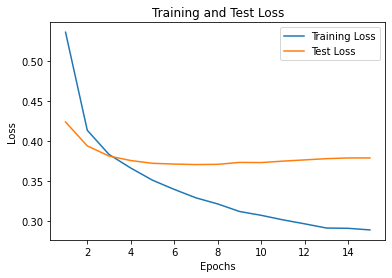

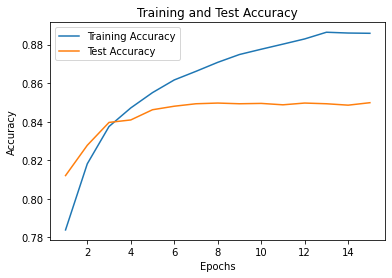

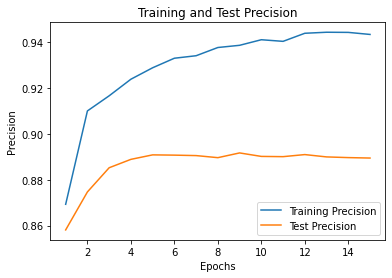

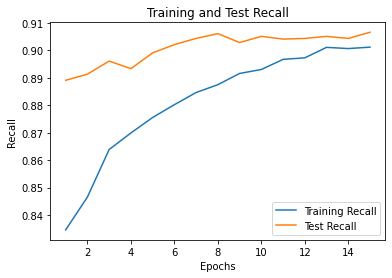

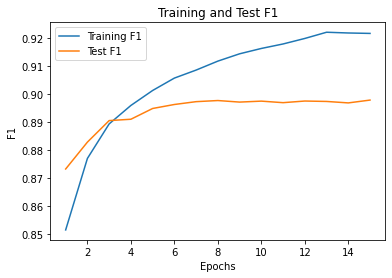

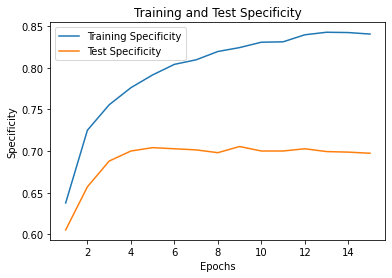

In [16]:
#Plot training and test loss
plt.plot(range(1, num_epochs+1), loss_values_train, label='Training Loss')
plt.plot(range(1, num_epochs+1), loss_values_test, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

#Plot training and test accuracy
plt.plot(range(1, num_epochs + 1), accuracy_train, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), accuracy_test, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

#Plot training and test precision
plt.plot(range(1, num_epochs + 1), precision_train, label='Training Precision')
plt.plot(range(1, num_epochs + 1), precision_test, label='Test Precision')
plt.title('Training and Test Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

#Plot training and test recall
plt.plot(range(1, num_epochs + 1), recall_train, label='Training Recall')
plt.plot(range(1, num_epochs + 1), recall_test, label='Test Recall')
plt.title('Training and Test Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.show()

#Plot training and test f1
plt.plot(range(1, num_epochs + 1), f_score_train, label='Training F1')
plt.plot(range(1, num_epochs + 1), f_score_test, label='Test F1')
plt.title('Training and Test F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='best')
plt.show()

#Plot training and test specificity
plt.plot(range(1, num_epochs + 1), specificity_train, label='Training Specificity')
plt.plot(range(1, num_epochs + 1), specificity_test, label='Test Specificity')
plt.title('Training and Test Specificity')
plt.xlabel('Epochs')
plt.ylabel('Specificity')
plt.legend(loc='best')
plt.show()

In [17]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

temp_X = tokenized_datasets_tweets_prep["train"]["input_ids"]
y = tokenized_datasets_tweets_prep["train"]["labels"].tolist()
max_len_x = 48

#change type of temp_X from tensor to list and make all entries the same length
X = []
for i in range(len(temp_X)):
  temp_list = temp_X[i].tolist()
  if(len(temp_list) != max_len_x):
    for i in range(max_len_x - len(temp_list)):
     temp_list.append(0)
  X.append(temp_list)

#Implementation of model from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier
baseline_model = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
baseline_model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier())])

In [31]:
temp_input = tokenized_datasets_tweets_prep["test"]["input_ids"]
input = []
max_len_x = 48

for i in range(len(temp_input)):
  temp_list = temp_input[i].tolist()
  if(len(temp_list) != max_len_x):
    for i in range(max_len_x - len(temp_list)):
     temp_list.append(0)
  input.append(temp_list)

predicted = baseline_model.predict(input)
references = tokenized_datasets_tweets_prep["test"]["labels"].tolist()

true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(len(predicted)):
  if(predicted[i] == 1 and references[i] == 1):
    true_positive += 1
  if(predicted[i] == 1 and references[i] == 0):
    false_positive += 1
  if(predicted[i] == 0 and references[i] == 1):
    false_negative += 1
  if(predicted[i] == 0 and references[i] == 0):
    true_negative += 1

print("TP:", true_positive, "TN:", true_negative, "FN:", false_negative, "FP:", false_positive)
precision = true_positive/(true_positive + false_positive)
recall = true_positive/(true_positive + false_negative)
f_score = 2*precision*recall / (precision + recall)
accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)
print("Baseline model - Precision:", precision, "Recall:", recall,
      "F_score:", f_score, "Specificity:", specificity, "Accuracy:", accuracy)

TP: 3992 TN: 3 FN: 2 FP: 1484
Baseline model - Precision: 0.7289992695398101 Recall: 0.99949924887331 F_score: 0.8430834213305174 Specificity: 0.0020174848688634837 Accuracy: 0.7288815909505565


Epoch 1
-------------------------------
TP: 3993 TN: 1 FN: 1 FP: 1486
Baseline model - Precision: 0.7287826245665268 Recall: 0.9997496244366549 F_score: 0.843027551989866 Accuracy: 0.728699142492246
Epoch 2
-------------------------------
TP: 3993 TN: 0 FN: 1 FP: 1487
Baseline model - Precision: 0.7286496350364964 Recall: 0.9997496244366549 F_score: 0.8429385687143762 Accuracy: 0.7285166940339354
Epoch 3
-------------------------------
TP: 3990 TN: 2 FN: 4 FP: 1485
Baseline model - Precision: 0.7287671232876712 Recall: 0.99899849774662 F_score: 0.8427500264019432 Accuracy: 0.7283342455756249
Epoch 4
-------------------------------
TP: 3993 TN: 1 FN: 1 FP: 1486
Baseline model - Precision: 0.7287826245665268 Recall: 0.9997496244366549 F_score: 0.843027551989866 Accuracy: 0.728699142492246
Epoch 5
-------------------------------
TP: 3985 TN: 5 FN: 9 FP: 1482
Baseline model - Precision: 0.7289189683555881 Recall: 0.9977466199298949 F_score: 0.8424056653630695 Accuracy: 0.7279693486590039
E

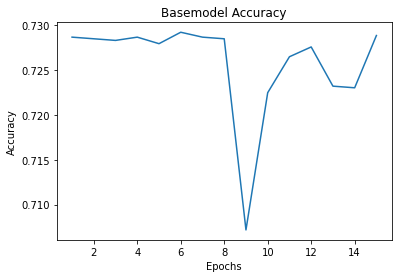

In [20]:
accuracy_basemodel = []

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    #Training
    baseline_model.fit(X, y)
    #Testing
    predicted = baseline_model.predict(input)
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for i in range(len(predicted)):
      if(predicted[i] == 1 and references[i] == 1):
        true_positive += 1
      if(predicted[i] == 1 and references[i] == 0):
        false_positive += 1
      if(predicted[i] == 0 and references[i] == 1):
        false_negative += 1
      if(predicted[i] == 0 and references[i] == 0):
        true_negative += 1

    print("TP:", true_positive, "TN:", true_negative, "FN:", false_negative, "FP:", false_positive)
    precision = true_positive/(true_positive + false_positive)
    recall = true_positive/(true_positive + false_negative)
    f_score = 2*precision*recall / (precision + recall)
    accuracy = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
    print("Baseline model - Precision:", precision, "Recall:", recall,
          "F_score:", f_score, "Accuracy:", accuracy)
    accuracy_basemodel.append(accuracy)

#Plot training and test accuracy
plt.plot(range(1, num_epochs + 1), accuracy_basemodel, label='Basemodel Accuracy')
plt.title('Basemodel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [21]:
outputs_after = []

with torch.no_grad():
    for video in eval_dataset:
      output_one_video = []
      for comment in video:
        input = tokenizer(comment, padding=True, truncation=True, return_tensors='pt')
        input.to(device)
        output = model(**input)
        #Get positive or negative evaluation of comment
        label_id = torch.argmax(output.logits).item()
        output_one_video.append(label_id)
        # label = model.config.id2label[label_id]
        # print(label_id, label)

      outputs_after.append(output_one_video)

print(len(outputs_after))
outputs_after_df = pd.DataFrame(outputs_after)
outputs_after_df.to_csv('Evaluation_after_finetuning.csv', encoding='utf-8')

183


In [30]:
total_same_eval = 0
total_diff_eval = 0
total_pos_before = 0
total_neg_before = 0
total_pos_after = 0
total_neg_after = 0

for idx1 in range(len(outputs_before)):
  for idx2 in range(len(outputs_before[idx1])):
    if outputs_before[idx1][idx2] == outputs_after[idx1][idx2]:
      total_same_eval += 1
    else:
      print("Comment:", eval_dataset[idx1][idx2], "Before:", outputs_before[idx1][idx2], "After:", outputs_after[idx1][idx2])
      total_diff_eval += 1
    if(outputs_after[idx1][idx2] == 0):
      total_neg_after += 1
    if(outputs_after[idx1][idx2] == 1):
      total_pos_after += 1
    if(outputs_before[idx1][idx2] == 0):
      total_neg_before += 1
    if(outputs_before[idx1][idx2] == 0):
      total_pos_before += 1

print("Total same evaluation:", total_same_eval)
print("Total different evaluation:", total_diff_eval)
print("Before - positive:", total_pos_before, "negative:", total_neg_before)
print("After - positive:", total_pos_after, "negative:", total_neg_after)

<class 'pandas.core.frame.DataFrame'>
[[1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0,